In [119]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [195]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
# MANIFEST_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Shah (BWH)_OLINK_SK-5T4V_2023-06-27_MN UPDATES 82823.xlsx"
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = ['SEC Fract 6 ', 'SEC Fract 7', 'SEC Fract 8', 'SEC Fract 9', 'SEC Fract 10', 'SEC Fract 11', 'SEC Fract 12', 'SEC Fract 13',
        'SEC Fract 14',  'SEC Fract 15',
        'CSF A Internal EV', 
       'CSF B Internal EV', 'CSF C Internal EV', 'CSF D Internal EV',
       'Plas A Internal EV', 'Plas B Internal EV', 'Plas C Internal EV',
       'Plasma D Internal EV']

CSF_SAMPLES = ['SEC Fract 6 ', 'SEC Fract 7', 'SEC Fract 8', 'SEC Fract 9', 'SEC Fract 10', 'SEC Fract 11', 'SEC Fract 12', 'SEC Fract 13',
        'SEC Fract 14',  'SEC Fract 15',
        'CSF A Internal EV', 
       'CSF B Internal EV', 'CSF C Internal EV', 'CSF D Internal EV',
]

In [121]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how = "left", on = "SampleID")

data["Linear NPX"] = data["NPX"].map(lambda x: 2**x)

In [129]:
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]
# vc
# # vc.value_counts()
# # vc.index.get_level_values(2).value_counts()
# repeated_markers = vc.index.get_level_values("UniProt").unique()

# markers_in_multiple_panels = data[
#     data["UniProt"].isin(repeated_markers) & (data["Sample_Type"] == "SAMPLE")
# ].pivot(columns=["UniProt", "Panel"], index="SampleID", values="Linear NPX")
# linear_lod = 2 ** (
#     data[
#         data["UniProt"].isin(repeated_markers)
#         & (data["Sample_Type"] == "SAMPLE")
#     ].pivot(columns=["UniProt", "Panel"], index="SampleID", values="LOD")
# )

# markers_in_multiple_panels["P14902"].std(axis=1) / markers_in_multiple_panels[
#     "P14902"
# ].mean(axis=1)

# fig, ax = plt.subplots()
# for marker in repeated_markers:
#     df = markers_in_multiple_panels[
#         markers_in_multiple_panels > linear_lod.fillna(-np.inf)
#     ][marker]
#     x = (df.std(axis=0) / df.mean(axis=0)).median()
#     y = (df.std(axis=1) / df.mean(axis=1)).median()
#     print(marker)
#     print(y)
#     ax.plot([x], [y], "o", alpha=0.25)
#     ax.text(x, y, marker, horizontalalignment="center", verticalalignment="center")
# ax.set(
#     aspect="equal",
#     xlim=(0, 3),
#     ylim=(0, 1),
#     xlabel="Median CV across samples",
#     ylabel="Median CV within sample",
# )

# plt.show()

# markers_in_multiple_panels[markers_in_multiple_panels > linear_lod.fillna(-np.inf)]

In [130]:
# normalize the data according to plate controls

ctrl_dict = {
    "Panel": [], 
    "Plate_ctrl": []
}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    ctrl_dict["Panel"].append(panel)
    ctrl_dict["Plate_ctrl"].append(plate_ctrl)

unique_uniprot_values = vc.index.get_level_values('UniProt').unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)]

raw_data_no_reps['Delta'] = raw_data_no_reps.apply(
    lambda row: row['Linear NPX'] - 
    ctrl_dict['Plate_ctrl'][ctrl_dict['Panel'].index(row['Panel'])],
    axis=1
)

# create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Delta"
)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_24828\2797443278.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_no_reps['Delta'] = raw_data_no_reps.apply(


In [124]:
# Anova test to determine significance of differences between healthy, mild cognitive impairment, and AD samples
assay_list = list(tidy_data.columns)

anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

healthy_df = tidy_data[tidy_data.index.get_level_values('Health') == 'Healthy']
mci_df = tidy_data[tidy_data.index.get_level_values('Health') == 'MCI']
ad_df = tidy_data[tidy_data.index.get_level_values('Health') == 'AD']


for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    statistic, p_value = f_oneway(healthy_assays, mci_assays, ad_assays)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

# print(anova_test["p-value"].mean())
# print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")

# tukey test to correct for differences between these groups
tk_output = pd.DataFrame()

for assay in sig_results["Assay"]:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])
    tk_input = pd.DataFrame(
        {
            "values": healthy_assays + mci_assays + ad_assays,
            "group": ["Healthy Samples"] * len(healthy_assays)
            + ["MCI Samples"] * len(mci_assays)
            + ["AD Samples"] * len(ad_assays),
        }
    )
    tukey_results = pairwise_tukeyhsd(tk_input["values"], tk_input["group"])
    tukey_df = pd.DataFrame(
        tukey_results.summary(), columns=tukey_results.data[0].dtype.names
    )
    tukey_df["Assay"] = assay
    tk_output = pd.concat([tk_output, tukey_df], axis=0)

tk_output = tk_output.rename(
    columns={
        0: "Group 1",
        1: "Group 2",
        2: "Mean Difference",
        3: "Adjusted p-value",
        4: "Lower",
        5: "Upper",
        6: "Reject?",
        "Assay": "Assay",
    }
)
# need to figure out how to drop the rows where "Group 1" is group1, etc.

0.4592800402439577
0.47286857127559767


In [166]:
# Graph CD63 medians to confirm correct fractionation pattern
# healthy_df = tidy_data[tidy_data.index.get_level_values('Health') == 'Healthy']

# cd63 = tidy_data["P08962"]
# cd63 = cd63.reset_index(level = ["SampleID", "Health", "Sample"])
# cd63["Sample"] = pd.Categorical(cd63["Sample"], categories=X_AXIS_ORDER, ordered=True)
# cd63_sorted = cd63.sort_values("Sample")
# grouped_data = [group["P08962"].values for name, group in cd63_sorted.groupby("Sample")]

# plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)
# plt.xlabel("Sample Description")
# plt.ylabel("Delta")
# plt.title("CD63 Fractionation Pattern")
# plt.xticks(range(1, len(X_AXIS_ORDER) + 1), X_AXIS_ORDER)
# plt.xticks(rotation=45, ha="right")
# plt.show()

In [165]:
# Graph some secreted protein medians

def graph_medians(target, uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level = ["SampleID", "Health", "Sample"])
    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)
    df_sorted = df.sort_values("Sample")
    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)
    plt.xlabel("Sample Description")
    plt.ylabel("Delta")
    plt.title(f"{target} Fractionation Pattern")
    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)
    plt.xticks(rotation=45, ha="right")
    plt.show()


# graph_medians("IL1RA", "P18510")
# graph_medians("Apolioprotein E", "P02649")
# graph_medians("Apolioprotein B", "P04114")

In [16]:
# TODO: see how many transmembrane/soluble/cytosolic proteins there are in the dataset and make a pie chart

In [174]:
tidy_data

,,UniProt,A0FGR8,A1E959,A1KZ92,A1L4H1,A2VDF0,A4D1B5,A6BM72,A6NC86,A6NCE7,A6NDB9,...,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6I3,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6U3,Q9Y6X8,Q9Y6Y9
SampleID,Health,Sample,,,,,,,,,,,,,,,,,,,,,
SM-N8JPG,Healthy,SEC Fract 6,0.063020,0.176086,-0.053836,-0.706210,NaN,0.023968,-0.373222,-0.909490,0.142401,-0.465689,...,0.059663,0.098567,0.146390,0.775640,-0.312535,-0.966143,-0.214901,-0.214055,0.074774,-0.049787
SM-N8JPH,Healthy,SEC Fract 7,-0.223583,0.337089,-0.686866,-0.758444,NaN,-0.336533,-0.424776,1.217914,0.010213,-0.578451,...,-0.279628,0.820012,-0.034934,0.420454,-0.147243,-1.015260,-0.193151,0.591645,-0.121451,0.438033
SM-N8JPI,Healthy,SEC Fract 8,-0.160486,0.015377,-0.237584,0.293557,NaN,0.210301,-0.307396,0.298798,0.147040,0.323063,...,-0.056870,-0.328806,0.340879,-0.305482,0.060257,-0.975486,0.692547,-0.820336,0.077924,-0.077439
SM-N8JPJ,Healthy,SEC Fract 9,0.365366,0.928696,-0.279861,1.631324,NaN,0.096063,-0.137570,-0.947915,0.052432,1.568611,...,0.228482,0.234928,0.313521,0.071569,-0.068996,-0.981577,-0.538702,0.267085,-0.169861,0.469933
SM-N8JPK,Healthy,SEC Fract 10,-0.240772,0.133221,-0.693027,1.304650,NaN,-0.396627,-0.157819,1.267991,-0.167786,-0.430309,...,1.240003,-0.092683,0.139678,0.391781,-0.047976,-0.425120,-0.110127,0.355039,-0.066181,-0.032248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-N8JS1,MCI,SEC Fract 12,-0.106238,0.503850,-0.340897,0.168733,NaN,-0.434021,5.925080,-0.905169,-0.268753,-0.380956,...,0.019468,0.079964,0.069222,-0.504069,-0.232948,199.099647,2.649937,0.585691,-0.029060,0.116568
SM-N8JS2,MCI,SEC Fract 13,-0.055881,0.156504,0.539899,0.234892,NaN,0.505921,11.638523,-0.324857,-0.094575,-0.695406,...,-0.289117,-0.247282,-0.200881,0.977131,-0.277587,473.674340,29.312050,-0.033223,-0.021732,0.561955
SM-N8JS3,MCI,SEC Fract 14,0.220220,0.163039,0.804629,0.210643,NaN,0.464887,15.898336,0.186816,-0.258363,-0.826109,...,0.080700,0.850259,-0.008401,0.100713,-0.185445,666.897405,410.357004,-0.581590,-0.179490,0.323625


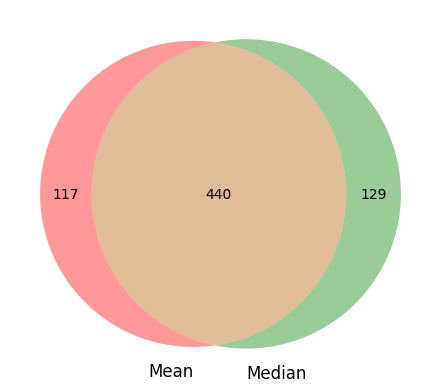

In [190]:
late_ev_fractions = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
                              | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")]

all_ev_fractions = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
                            | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
                            | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
                            | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")]

early_soluble_fractions = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
                              | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")]

late_soluble_fractions = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
                              | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")]

mean_assays = []
median_assays = []

for assay in list(tidy_data.columns):
    late_ev_median = late_ev_fractions[assay].median()
    all_ev_median = all_ev_fractions[assay].median()
    early_soluble_median = early_soluble_fractions[assay].median()
    late_soluble_median = late_soluble_fractions[assay].median()

    late_ev_mean = late_ev_fractions[assay].mean()
    all_ev_mean = all_ev_fractions[assay].mean()
    early_soluble_mean = early_soluble_fractions[assay].mean()
    late_soluble_mean = late_soluble_fractions[assay].mean()

    if ((late_ev_mean > early_soluble_mean) and (all_ev_mean > late_soluble_mean)) or ((all_ev_mean > early_soluble_mean) and (late_ev_mean > late_soluble_mean)):
        mean_assays.append(assay)
    if ((late_ev_median > early_soluble_median) and (all_ev_median > late_soluble_median)) or ((all_ev_median > early_soluble_median) and (late_ev_median > late_soluble_median)):
        median_assays.append(assay)


venn2(
    [set(mean_assays), set(median_assays)],
    set_labels=("Mean", "Median"),
)
plt.show()

In [193]:
def calculate_means_and_merge(cell_type_df, not_mean_calc):
    values = cell_type_df.drop(not_mean_calc, axis=1)
    values["Mean"] = values.apply(lambda row: row.mean(), axis=1)
    means = pd.merge(cell_type_df, values["Mean"], left_index=True, right_index=True)
    return means


def filter_targets(cell_type_means, other_means, threshold):
    return cell_type_means[cell_type_means["Mean"] > (threshold * other_means["Mean"])]


def process_cell_type(brain_rna_seq, cell_type_cols, not_mean_calc, threshold):
    cell_type_df = brain_rna_seq[cell_type_cols]
    cell_type_means = calculate_means_and_merge(cell_type_df, not_mean_calc)

    for other_cell_type_cols in [
        c
        for c in [
            mature_astrocytes_cols,
            microglia_cols,
            oligodendrocyte_cols,
        ]
        if c != cell_type_cols
    ]:
        other_means = calculate_means_and_merge(
            brain_rna_seq[other_cell_type_cols], not_mean_calc
        )
        cell_type_targets = filter_targets(cell_type_means, other_means, threshold)
        cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
            " - ", expand=True
        )
        return cell_type_targets


# Read the brain RNA-seq data
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Define columns for each cell type
mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
not_mean_calc = ["gene_id", "id"]

# Define the threshold for 3x enrichment
cell_type_enrichment_threshold = 3

# Process each cell type
mature_astrocyte_targets = process_cell_type(
    brain_rna_seq, mature_astrocytes_cols, not_mean_calc, cell_type_enrichment_threshold
)
microglia_targets = process_cell_type(
    brain_rna_seq, microglia_cols, not_mean_calc, cell_type_enrichment_threshold
)
oligodendrocyte_targets = process_cell_type(
    brain_rna_seq, oligodendrocyte_cols, not_mean_calc, cell_type_enrichment_threshold
)

# map the hgnc id's to the uniprot id's

response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t")


def uniprot_and_fractionation(df):
    df = pd.merge(
        df,
        uniprot_ids[["hgnc_id", "uniprot_ids"]],
        left_on="id",
        right_on="hgnc_id",
        how="left",
    )
    return df[df["uniprot_ids"].isin(median_assays)]


mature_astrocyte_targets = uniprot_and_fractionation(mature_astrocyte_targets)
microglia_targets = uniprot_and_fractionation(microglia_targets)
oligodendrocyte_targets = uniprot_and_fractionation(oligodendrocyte_targets)

# microglia_targets = pd.merge(
#     microglia_targets,
#     uniprot_ids[["hgnc_id", "uniprot_ids"]],
#     left_on="id",
#     right_on="hgnc_id",
#     how="left",
# )

# microglia_targets = microglia_targets[
#     microglia_targets["uniprot_ids"].isin(correct_fractionation_median)
# ]

# # Overlay with correct_fractionation_median list
# def find_correct_fractionation(df):
#     return df[df[]]

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_24828\741182899.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_24828\741182899.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_24828\741182899.py:29: SettingWithCopyWarning: 
A value is trying to

In [199]:
mature_astrocyte_targets

,gene_id,id,astrocytes_mature_1,astrocytes_mature_2,astrocytes_mature_3,astrocytes_mature_4,astrocytes_mature_5,astrocytes_mature_6,astrocytes_mature_7,astrocytes_mature_8,astrocytes_mature_9,astrocytes_mature_10,astrocytes_mature_11,astrocytes_mature_12,Mean,Gene,Species,hgnc_id,uniprot_ids
87,ADRA2A - Homo sapiens,HGNC:281,0.678198,0.173273,0.452411,0.396646,0.237014,1.226130,0.250625,0.149043,0.22869,1.158340,0.363681,0.499018,0.484422,ADRA2A,Homo sapiens,HGNC:281,P08913
112,AK1 - Homo sapiens,HGNC:361,3.810280,2.450220,2.572160,1.597050,4.224460,3.161530,1.206330,1.168030,1.68990,0.886813,1.191420,0.930365,2.074047,AK1,Homo sapiens,HGNC:361,P00568
126,AKT2 - Homo sapiens,HGNC:392,5.079630,1.914230,3.154730,2.064840,1.865280,2.962590,0.766728,0.770739,2.00288,0.839063,0.838039,0.848361,1.925592,AKT2,Homo sapiens,HGNC:392,P31751
133,ALDH2 - Homo sapiens,HGNC:404,162.150000,146.520000,134.098000,145.878000,217.512000,169.859000,115.005000,195.659000,131.37400,99.976100,156.170000,115.007000,149.100675,ALDH2,Homo sapiens,HGNC:404,P05091
188,AP3S2 - Homo sapiens,HGNC:571,5.515290,4.084910,5.569140,4.683150,7.201500,6.400690,4.411780,3.497460,2.50245,2.618360,5.162770,2.570240,4.518145,AP3S2,Homo sapiens,HGNC:571,P59780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,TRAF3IP2 - Homo sapiens,HGNC:1343,6.679710,8.350290,8.358880,2.152220,7.833920,1.695360,7.328490,7.174440,7.19331,1.312660,1.137830,5.699620,5.409727,TRAF3IP2,Homo sapiens,HGNC:1343,O43734
3409,TRDMT1 - Homo sapiens,HGNC:2977,1.220460,1.232810,1.861490,1.186360,0.596274,1.470660,0.675719,1.112520,1.75272,1.306330,0.589548,0.676563,1.140121,TRDMT1,Homo sapiens,HGNC:2977,O14717
3430,TRPV3 - Homo sapiens,HGNC:18084,0.495114,0.452031,0.516276,0.787940,0.253577,0.497889,0.100000,0.155922,0.59339,0.686080,0.232375,0.244614,0.417934,TRPV3,Homo sapiens,HGNC:18084,Q8NET8
3446,TSPAN7 - Homo sapiens,HGNC:11854,228.296000,261.328000,356.230000,254.191000,318.771000,230.306000,181.011000,180.571000,192.44400,218.651000,228.355000,175.746000,235.491667,TSPAN7,Homo sapiens,HGNC:11854,P41732


In [201]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)
# map uniprot id's to fasta
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""

    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict


protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

mature_astrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
microglia_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
oligodendrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

# fetal_astrocyte_targets = fetal_astrocyte_targets.drop(fetal_astrocytes_cols, axis = 1)
# mature_astrocyte_targets = mature_astrocyte_targets.drop(mature_astrocytes_cols, axis = 1)
# endothelial_targets = endothelial_targets.drop(endothelial_cols, axis = 1)
# microglia_targets = microglia_targets.drop(microglia_cols, axis=1)
# oligodendrocyte_targets = oligodendrocyte_targets.drop(oligodendrocyte_cols, axis = 1)


# export the list of proteins in fasta format to be input into the online program
# link to program: https://dtu.biolib.com/DeepTMHMM
def export_fasta(output_path, df):
    with open(output_path, "w") as output_file:
        for index, row in df.iterrows():
            output_file.write(f'>{row["uniprot_ids"]}\n')
            output_file.write(f'{row["Sequence"]}\n')

export_fasta(MATURE_ASTROCYTE_FASTA_OUTPUT_PATH, mature_astrocyte_targets)
export_fasta(MICROGLIA_FASTA_OUTPUT_PATH, microglia_targets)
export_fasta(OLIGODENDROCYTE_FASTA_OUTPUT_PATH, oligodendrocyte_targets)

In [208]:
microglia_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_microglia"
)
oligodendrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_oligodendrocyte"
)
mature_astrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_mature_astrocytes"
)

deeptmhmm = biolib.load("DTU/DeepTMHMM")


# def tmhmm_localization(targets, output_directory):
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
#     os.chdir(output_directory)
#     for row in targets.iterrows():
#         sequence = targets["Sequence"]
#         uniprot_id = targets["uniprot_ids"]
#         fasta_line = f">{uniprot_id}\n{sequence}\n"
#         print(fasta_line)
#         with open("query.fasta", "w") as fasta_file:
#             fasta_file.write(fasta_line)
def tmhmm_localization(targets, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    os.chdir(output_directory)

    # Open the file outside the loop
    with open("query.fasta", "w") as fasta_file:
        for _, row in targets.iterrows():
            sequence = row["Sequence"]
            uniprot_id = row["uniprot_ids"]
            fasta_line = f">{uniprot_id}\n{sequence}\n"
            print(fasta_line)
            fasta_file.write(fasta_line)
        biolib.utils.STREAM_STDOUT = True  # Stream progress from app in real time
        deeptmhmm_job = deeptmhmm.cli(
            args="--fasta query.fasta", machine="local"
        )  # Blocks until done
        deeptmhmm_job.save_files(output_directory)  # Saves all results to `result` dir


tmhmm_localization(microglia_targets, microglia_output_directory)
tmhmm_localization(oligodendrocyte_targets, oligodendrocyte_output_directory)
tmhmm_localization(mature_astrocyte_targets, mature_astrocyte_output_directory)

2023-12-04 15:39:37,141 | INFO : Loaded project DTU/DeepTMHMM:1.0.24
>P33121
MDALQLANSAFAVDLFKQLCEKEPLGNVLFSPICLSTSLSLAQVGAKGDTANEIGQVLHFENVKDVPFGFQTVTSDVNKLSSFYSLKLIKRLYVDKSLNLSTEFISSTKRPYAKELETVDFKDKLEETKGQINNSIKDLTDGHFENILADNSVNDQTKILVVNAAYFVGKWMKKFSESETKECPFRVNKTDTKPVQMMNMEATFCMGNIDSINCKIIELPFQNKHLSMFILLPKDVEDESTGLEKIEKQLNSESLSQWTNPSTMANAKVKLSIPKFKVEKMIDPKACLENLGLKHIFSEDTSDFSGMSETKGVALSNVIHKVCLEITEDGGDSIEVPGARILQHKDELNADHPFIYIIRHNKTRNIIFFGKFCSP

>P07355
MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSLCHTDATVIDSKFEGLAFPVIVGHEAAGIVESIGPGVTNVKPGDKVIPLYAPLCRKCKFCLSPLTNLCGKISNLKSPASDQQLMEDKTSRFTCKGKPVYHFFGTSTFSQYTVVSDINLAKIDDDANLERVCLLGCGFSTGYGAAINNAKVTPGSTCAVFGLGGVGLSAVMGCKAAGASRIIGIDINSEKFVKAKALGATDCLNPRDLHKPIQEVIIELTKGGVDFALDCAGGSETMKAALDCTTAGWGSCTFIGVAAGSKGLTIFPEELIIGRTINGTFFGGWKSVDSIPKLVTDYKNKKFNLDALVTHTLPFDKISEAFDLMNQGKSVRTILIF

>P62330
MYLSICCCFLLWAPALTLKNLNYSVPEEQGAGTVIGNIGRDARLQPGLPPAERGGGGRSKSGSYRVLENSAPHLLDVDADSGLLYTKQRIDRESLCRHNAKCQLSLEVFANDKEICMIKVEIQDINDNAPSFSSDQIEMDISENAAPG

In [ ]:
# output_directory = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm1_microglia"

# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# os.chdir(output_directory)

# deeptmhmm = biolib.load("DTU/DeepTMHMM")

# for (
#     _,
#     row,
# ) in (
#     microglia_targets.iterrows()
# ):  # there has got to be a way to make this faster this is insanely slow
#     sequence = row["Sequence"]
#     print(sequence)
#     uniprot_id = row["uniprot_ids"]
#     print(uniprot_id)
#     # !echo -e f">{uniprot_id}\n{sequence}\n" > query.fasta
#     fasta_line = f">{uniprot_id}\n{sequence}\n"
#     with open("query.fasta", "w") as fasta_file:
#         fasta_file.write(fasta_line)
#     deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta")
#     print(deeptmhmm_job)
#     deeptmhmm_job.save_files(output_directory)
#     Image(filename="plot.png")
# is there a way to import all the files from the directory for bulk analysis?
# I think with each iteration of the loop it's incorrectly trying to change the name of the output file to add to the directory, making an inaccessible output file
# program (should) output an image of the plot (.png), and gff3/3line/md/csv files

In [ ]:
# make a list of the areas in which each target is localized
paths = [
    file.path
    for file in os.scandir(microglia_output_directory)
    if file.name.endswith(".csv")
]

target_loc = {}

for item in paths:
    df = pd.read_csv(item)
    id = df.columns[0]
    df = df.reset_index(drop=False)
    df.columns = df.iloc[0]
    df = df[1:]
    df[["#", "AA"]] = df["#AA"].str.split(expand=True)
    df = df.drop("#AA", axis=1)

    columns_list = ["Beta", "Periplasm", "Membrane", "Inside", "Outside", "Signal"]
    signal_columns = []
    for column in columns_list:
        selected_column = df[column]
        all_zero = all(value == "0.0" for value in selected_column)
        if all_zero is False:
            signal_columns.append(column)
    target_loc[id] = signal_columns

ParserError: Error tokenizing data. C error: Expected 7 fields in line 577, saw 8


In [ ]:
target_loc

{}

In [ ]:
# TODO: re-write the program to be run in the opposite order to make sure the output is the same (do transmembrane, then brain rna seq, and then fractionation pattern instead of the other way around)